# Identifying racial bias in health data
> We are becoming more and more reliant on machine learning algorithms in our everyday lives. But what if these algorithms aren't fair? In this exploratory data analysis of Obermeyer et al. 2019, we look at how racial biases can creep in to an algorithm's decision-making process.

- toc: true
- badges: false
- comments: true
- author: John F Wu
- categories: [big data, health, ethical ai, machine learning]
- image: images/healthcare-bias.png



>Note: Following the change in the [AP Stylebook](https://blog.ap.org/announcements/the-decision-to-capitalize-black), and many others who have been  [advocating](https://www.brookings.edu/blog/the-avenue/2020/06/16/a-public-letter-to-the-associated-press-listen-to-the-nation-and-capitalize-black/) [it](https://www.csmonitor.com/Commentary/2020/0612/The-case-for-uppercase-Commentary-on-style-dignity-and-Black-culture) [for](https://www.nytimes.com/2014/11/19/opinion/the-case-for-black-with-a-capital-b.html) [years](https://www.poynter.org/reporting-editing/2015/making-the-case-for-black-with-a-capital-b-again/), I will be capitalizing the b in Black when referring to the racial, cultural, and ethnic identity.

In [1]:
#hide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

ROOT = Path('..').resolve()

# plotting stuff
%matplotlib inline

white_plot_args = {
    'label': 'White',
    'color': '#ff6361',
}

black_plot_args = {
    'label': 'Black',
    'color': '#003f5c',
}

legend_args = dict(framealpha=0, markerscale=1.3, fontsize=14)

I recently read the incredible paper, [*Dissecting racial bias in an algorithm used to manage the health of populations*](https://science.sciencemag.org/content/366/6464/447), by Obermeyer et al. (2019). The authors analyzed an algorithm that was commonly used for evaluating patients' health risks and determining which patients should be enrolled in a care management program. The authors compared the algorithm's risk score with a number of patient outcomes, including medical costs and total number of chronic illnesses. They found evidence of **racial bias** in the algorithm, which could lead to worse health outcomes for Black patients than white patients given the same algorithm risk score. 

Because of US privacy law concerning protected health information, or PHI, the study was not able to publish the original hospital patient data. Instead, they released a synthetic data set generated with the [`synthpop`](https://cran.r-project.org/web/packages/synthpop/vignettes/synthpop.pdf) R package. These data (and tools for their analysis) can be found in [their Gitlab repo](https://gitlab.com/labsysmed/dissecting-bias).

>Note: I try to recreate some of the authors' results solely based on the synthetic data set, and by examining their paper and figures. They do have code available for reproducing the analysis, but since I didn't look at it, my quick exploratory data analysis may differ from their results. Also, the synthetic data may not agree perfectly with the original data.

# A (synthetic) health care data set

First, let's take a look at the data. The data [README](https://gitlab.com/labsysmed/dissecting-bias/-/blob/master/data/data_dictionary.md) was particularly helpful for understanding the contents of the table. For example, columns ending in `_t` are measures of outcomes during time $t$, and columns ending in `_tm1` are data from the preceding year (including comorbidity and biomarker indicators used for training the algorithm). Here are a few rows from the data set, read in from the CSV using `pandas`:

In [2]:
df = pd.read_csv(f'{ROOT}/data/data_new.csv')
df.sample(3)

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
30989,0.594530,0,2700.0,0.0,110.0,NaN,37.9,NaN,NaN,white,...,0,0,0,0,0,0,0,0,1,1
36979,2.242229,0,900.0,0.0,126.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,2,2
29424,2.021403,0,51200.0,0.0,126.0,NaN,42.2,0.94,NaN,white,...,0,0,0,0,0,0,0,0,2,1


We will work with the Black and white populations separately in order to probe any racial disparity in health outcomes.

In [3]:
white = df[df.race == 'white']
black = df[df.race == 'black']

len(white), len(black)

(43202, 5582)

We can see that about 88% of the patients are white. Patients who identify as another race are not included in the data. Note that the same patient can appear multiple times in the original data, as each row represents a single year of patient data; I haven't made any statistical corrections for this.

# No racial disparity in medical costs

The algorithm is trained to predict patients' future medical costs as a way of identifying those who would benefit from enrolling in a health care coordination program. *Future medical costs* are frequently used as the objective function (think negative loss function) for training such algorithms; this algorithm seeks to identify patients with the highest predicted costs. The authors point out that other objectives (or "labels") can be used as well.

Next, I try to recreate the results shown in Figure 3a of Obermeyer et al. (2019):

![](images/O19_fig3a.jpg "Fig. 3a from Obermeyer et al. 2019.") 

The race-disaggregated patients are binned by risk score *percentile*, and then the mean medical cost is computed for each bin. Note the logarithmic y-axis. These kinds of plots seem to be common in economics (for example, the [Opportunity Insights](https://opportunityinsights.org/data/) research by Raj Chetty and collaborators), although I rarely see data illustrated this way in physics or astronomy.

Fortunately, with `pandas`, we can bin the risk score by quantile using `pd.qcut()`. We then feed the output into the powerful `DataFrame.grouby()` function in order to get binned statistics, from which we compute the average mean cost.

In [4]:
bins = np.arange(1, 100, 2)

white_cost_means = white.groupby(pd.qcut(white.risk_score_t, q=50)).cost_t.mean() / 1e3
black_cost_means = black.groupby(pd.qcut(black.risk_score_t, q=50)).cost_t.mean() / 1e3

Here is a scatter plot of the mean medical costs, in thousands of US dollars, as a function of risk score percentile. 

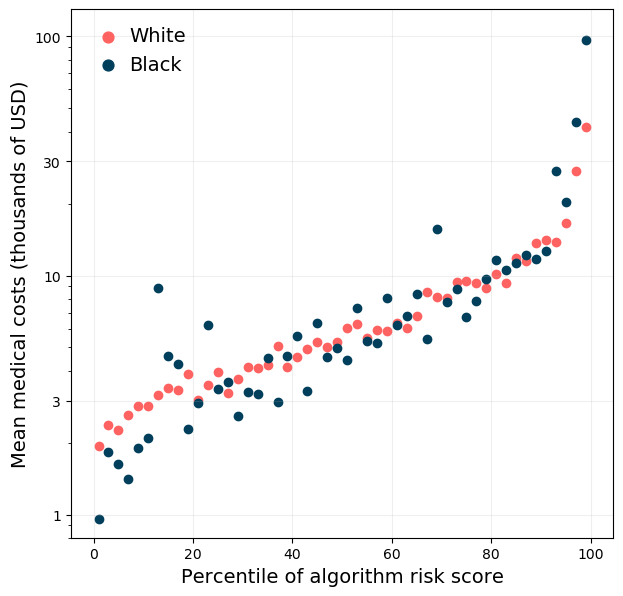

In [5]:
#hide_input
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(bins, white_cost_means, **white_plot_args)
plt.scatter(bins, black_cost_means, **black_plot_args)

plt.ylabel('Mean medical costs (thousands of USD)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.ylim(0.8, 130)
plt.yscale('log')
plt.gca().set_yticks([1, 3, 10, 30, 100])
plt.gca().set_yticklabels([1, 3, 10, 30, 100])

plt.legend(**legend_args, handletextpad=0.1)
plt.grid(alpha=0.2);

Qualitatively, we find the same results as the original paper. This is no evidence for racial disparity so far, but this result should not surprise us. The y-axis is the training objective for the algorithm that also produces the risk score, and race data are excluded from these predictions. Thus, it is expected that no *explicit* racial bias appears... yet.

# Number of chronic illnesses as a health outcome

So far so good, right? But wait, medical cost is not the only outcome that we should care about. Health outcomes are arguably more important than medical costs, and one way to measure health outcomes is to count how many chronic conditions a patient has.

Below, I plot histograms of the *number of active chronic illnesses* during year $t$ for white and Black patients. (For some reason, this column is named `gagne_sum_t` in the CSV file.) Most patients have zero or one active chronic conditions, and are exponentially less likely to have more than that.

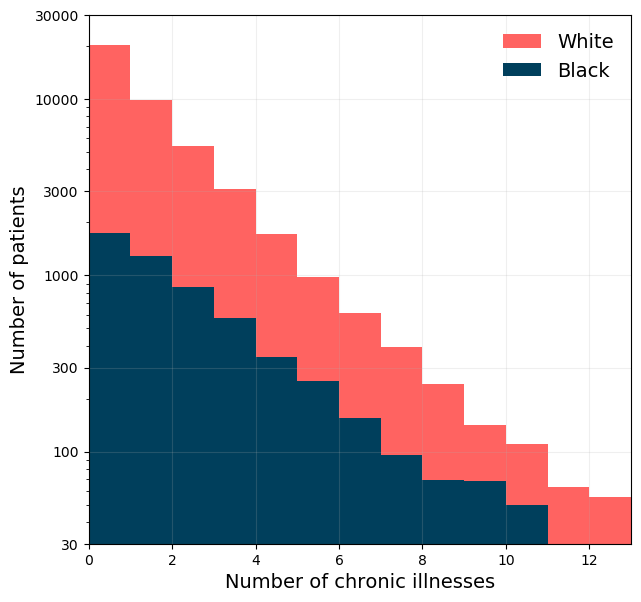

In [6]:
#hide_input
plt.figure(figsize=(7, 7), dpi=100)

white.gagne_sum_t.hist(range=(0, 15), bins=15, **white_plot_args)
black.gagne_sum_t.hist(range=(0, 15), bins=15, **black_plot_args)

plt.xlim(0, 13)
plt.ylim(3e1, 3e4)
plt.yscale('log')

plt.gca().set_yticks([30, 100, 300, 1000, 3000, 10000, 30000])
plt.gca().set_yticklabels([30, 100, 300, 1000, 3000, 10000, 30000])

plt.xlabel('Number of chronic illnesses', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)

plt.legend(**legend_args)
plt.grid(alpha=0.2);

# Revealing racial disparity in health outcomes

Let's now plot the average number of chronic illnesses at given risk score percentile for Black and white patients.

In [7]:
white_gagne_means = white.groupby(pd.qcut(white.risk_score_t, q=50)).gagne_sum_t.mean()
black_gagne_means = black.groupby(pd.qcut(black.risk_score_t, q=50)).gagne_sum_t.mean()

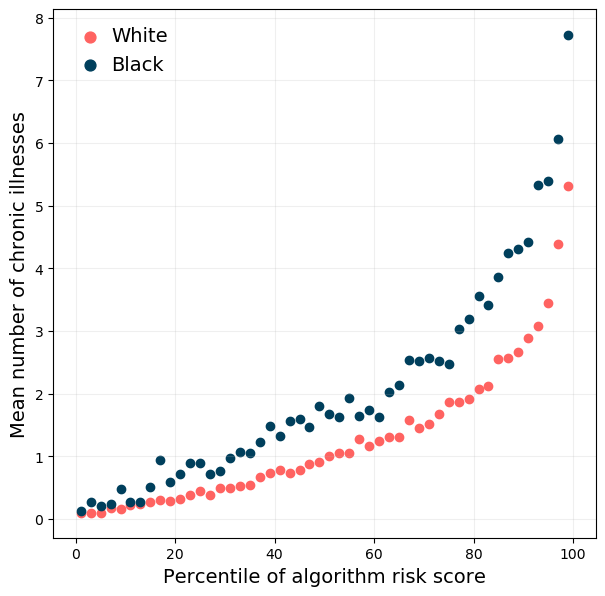

In [8]:
#hide_input
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(bins, white_gagne_means, **white_plot_args)
plt.scatter(bins, black_gagne_means, **black_plot_args)

plt.ylabel('Mean number of chronic illnesses', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.legend(**legend_args, handletextpad=0.1)
plt.grid(alpha=0.2);

There is now a noticeable gap between Black and white patients. And according to the analysis by Obermeyer et al., this gap ([also seen in their Figure 1a](https://science.sciencemag.org/content/sci/366/6464/447/F1.large.jpg)) is statistically significant. So what are the implications of this disparity?

The original purpose of the algorithm in question was to determine who to enroll into a care coordination program. Black patients only made up 17.7% of the population based on the medical cost metric. If instead the algorithm were trained to achieve parity in mean number of chronic illnesses, then 46.5% of patients identified for enrollment would be Black. **In essence, Black patients with pressing medical needs were systematically left out due to the algorithmic choice of *medical cost* as its objective function.**

# Higher medical expenditures for white patients

If Black and white patients have similar average medical costs given the same level of risk, then why do they have disparate *health* outcomes? One possible explanation is that white patients generate higher costs than Black patients even if they are equally healthy. 

Obermeyer et al. probe this mechanism by plotting the mean medical costs by number of chronic conditions, shown in their Figure 3b:

![](images/O19_fig3b.jpg "Fig. 3b from Obermeyer et al. 2019.")

Let's see if we can replicate this! However—again, having not looked at their code—I am not sure how they bin the number of chronic conditions by percentile, given that over 30% of the patients have zero chronic conditions. 

We can still explore the data in a similar way: by plotting the mean medical costs for white and Black patients, conditioned on the number of chronic illnesses.

In [9]:
gagne_bins = pd.interval_range(start=0, end=8, freq=1, closed='left')

white_costs_by_gagne = white.groupby(pd.cut(white.gagne_sum_t, gagne_bins, include_lowest=True)).cost_t.mean() / 1e3
white_num_by_gagne = pd.cut(white.gagne_sum_t, gagne_bins).value_counts()

black_costs_by_gagne = black.groupby(pd.cut(black.gagne_sum_t, gagne_bins, include_lowest=True)).cost_t.mean() / 1e3
black_num_by_gagne = pd.cut(black.gagne_sum_t, gagne_bins).value_counts()

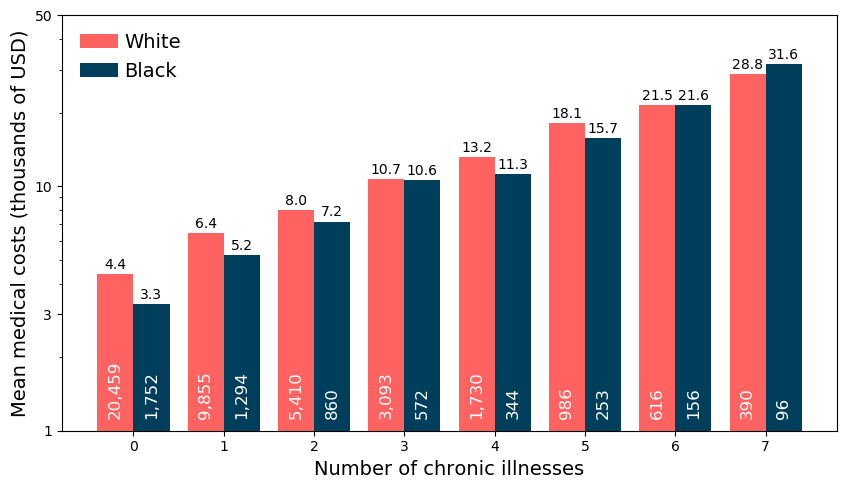

In [10]:
#hide_input
plt.figure(figsize=(10, 5.5), dpi=100)

plt.bar(np.arange(8) - 0.2, white_costs_by_gagne, width=0.4, **white_plot_args)
plt.bar(np.arange(8) + 0.2, black_costs_by_gagne, width=0.4, **black_plot_args)

for x, [white_cost, white_num, black_cost, black_num] in enumerate(
    zip(white_costs_by_gagne, white_num_by_gagne, black_costs_by_gagne, black_num_by_gagne)
):
    plt.text(x-0.2, white_cost*1.05, f'{white_cost:.1f}', ha='center', color='black', fontsize=10)
    plt.text(x+0.2, black_cost*1.05, f'{black_cost:.1f}', ha='center', color='black', fontsize=10)
    
    plt.text(x-0.2, 1.15, f'{white_num:,d}', ha='center', color='white', fontsize=12, rotation=90)
    plt.text(x+0.2, 1.15, f'{black_num:,d}', ha='center', color='white', fontsize=12, rotation=90)
    
    
plt.ylim(1, 50)
plt.yscale('log')
plt.gca().set_yticks([1, 3, 10, 50])
plt.gca().set_yticklabels([1, 3, 10, 50])
plt.legend(**legend_args, handletextpad=0.3)

plt.ylabel(r'Mean medical costs (thousands of USD)', fontsize=14)
plt.xlabel('Number of chronic illnesses', fontsize=14);

This plot shows the same qualitative trend as the original paper's result. For the majority of Black and white patients with zero or one chronic illnesses, there are substantial disparities in medical costs, whereby Black patients generate lower medical costs.

I want to leave a quote from the original paper (emphasis mine) that demonstrates how pernicious this effect can be.
> To summarize, we find substantial disparities in health conditional on risk but little disparity in costs. On the one hand, this is surprising: Health care costs and health needs are highly correlated, as sicker patients need and receive more care, on average. On the other hand, **there are many opportunities for a wedge to creep in between needing health care and receiving health care—and crucially, we find that wedge to be correlated with race** [...].

# Anti-racism and mitigating bias in machine learning

We see a clear picture of how racial disparities can manifest due to choice of objective function. The machine learning algorithm was trained to identify the most expensive patients based on comorbidity variables and biomarkers, as is commonly done in the health care world (and, in this case, the algorithm was developed by an "industry leader in data and analytics"). We see that patients' *algorithm risk scores* correlate with their *medical expenditures* during the following year, and that there is no racial disparity in this correlation. However, medical costs are not necessarily good proxies for health outcomes. If we examine the *number of chronic illnesses* as a function of algorithm risk score instead, then it becomes clear that Black patients have worse health outcomes at any given predicted risk score. [Obermeyer et al. (2019)](https://science.sciencemag.org/content/366/6464/447) also look at other health outcomes (e.g., diabetes severity), and find similar racial biases. They describe the problem succinctly in their paper's abstract:
> The bias arises because the algorithm predicts health care costs rather than illness, but unequal access to care means that we spend less money caring for Black patients than for White patients. Thus, despite health care cost appearing to be an effective proxy for health by some measures of predictive accuracy, large racial biases arise. 

One reason for this racial disparity may be that white patients have higher medical costs than Black patients given the number of active chronic illnesses. These could be caused or compounded by inequitable access to health care and unequal treatment at health care facilities (see, e.g., [brief results from a notebook I made to explore this](https://nbviewer.jupyter.org/github/jwuphysics/health-data/blob/master/medicare-current-beneficiary-survey_2013/notebook/A%20more%20detailed%20look%20at%20access%20to%20medical%20care.ipynb) based on 2013 Medicare Current Beneficiary Survey data). We also know that inequitable distribution of medical resources is causing health disparities during the coronavirus pandemic even now (i.e., [African Americans showing COVID-19 symptoms are less likely to receive treatment](https://rubixls.com/wp-content/uploads/2020/04/COVID-19-Minority-Health-Access-7-1.pdf)).

Fortunately, the authors present a solution, at least for the biased algorithm in the study. Instead of training the algorithm on medical costs, they use a combination of costs and health predictors as the training target and (at time of publication) are able to reduce racial bias by 84%. The takeaway is that **it is possible—and thus ethically imperative—to reduce bias in machine learning algorithms**, even as we make every effort to rectify human biases. It is a difficult task, of course, and data scientists will need to partner with domain experts in order to understand the many ways that algorithmic bias can appear. By exploring the data and forming teams with diverse backgrounds, we will be better equipped to handle biased data and correct biased algorithms.